In [ ]:
!pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.5 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

dataset = load_dataset("Matthijs/snacks")


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

In [ ]:
# Install necessary libraries
!pip install torch torchvision transformers
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
from torchvision.transforms import (
    Compose,
    Normalize,
    RandomResizedCrop,
    RandomHorizontalFlip,
    RandomAdjustSharpness,
    ToTensor,
)
from transformers import ViTFeatureExtractor
import os
import glob

# Define a function to check if an image is a valid JPG image
def is_valid_image(image_path):
    try:
        img = Image.open(image_path)
        if img.format in ["JPEG", "JPG"]:
            img.convert("RGB")  # Convert to RGB to ensure it's a valid image
            return True
    except Exception as e:
        return False

# Define dataset paths
data_path = '/content/data'  # Update with the correct path to your "data" folder
train_dataset_path = os.path.join(data_path, 'train')
val_dataset_path = os.path.join(data_path, 'val')
test_dataset_path = os.path.join(data_path, 'test')

# Define a function to load images from a directory
def load_images_from_directory(directory):
    image_paths = glob.glob(os.path.join(directory, '*', '*.jpg'))
    valid_image_paths = [path for path in image_paths if is_valid_image(path)]
    return valid_image_paths

# Load datasets
train_image_paths = load_images_from_directory(train_dataset_path)
val_image_paths = load_images_from_directory(val_dataset_path)
test_image_paths = load_images_from_directory(test_dataset_path)

# Define the Siamese network architecture
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 53 * 53, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
        )

    def forward_one(self, x):
        x = self.cnn(x)
        x = x.view(x.size()[0], -1)
        x = self.fc(x)
        return x

    def forward(self, input1, input2):
        output1 = self.forward_one(input1)
        output2 = self.forward_one(input2)
        return output1, output2

# Define the TripletDataset
class TripletDataset(Dataset):
    def __init__(self, image_paths, transform=None, image_size=(224, 224)):
        self.image_paths = image_paths
        self.transform = transform
        self.image_size = image_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        anchor_image_path = self.image_paths[index]

        try:
            anchor_image = Image.open(anchor_image_path).convert("RGB")  # Convert to RGB
        except Exception as e:
            print(f"Error opening image at index {index}: {e}")
            return None

        # Resize all images to the same dimensions
        anchor_image = anchor_image.resize(self.image_size, Image.LANCZOS)

        anchor = self.transform(anchor_image)

        positive_index = index
        while positive_index == index:
            positive_index = np.random.randint(0, len(self.image_paths))
        positive_image_path = self.image_paths[positive_index]

        try:
            positive_image = Image.open(positive_image_path).convert("RGB")  # Convert to RGB
        except Exception as e:
            print(f"Error opening image at index {positive_index}: {e}")
            return None

        # Resize all images to the same dimensions
        positive_image = positive_image.resize(self.image_size, Image.LANCZOS)

        positive = self.transform(positive_image)

        negative_index = index
        while negative_index == index or negative_index == positive_index:
            negative_index = np.random.randint(0, len(self.image_paths))
        negative_image_path = self.image_paths[negative_index]

        try:
            negative_image = Image.open(negative_image_path).convert("RGB")  # Convert to RGB
        except Exception as e:
            print(f"Error opening image at index {negative_index}: {e}")
            return None

        # Resize all images to the same dimensions
        negative_image = negative_image.resize(self.image_size, Image.LANCZOS)

        negative = self.transform(negative_image)

        return anchor, positive, negative

# Check if a CUDA-compatible GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the ViT feature extractor
checkpoint = "google/vit-base-patch16-224-in21k"
feature_extractor = ViTFeatureExtractor.from_pretrained(checkpoint)

# Define augmentation and normalization transforms
train_aug_transforms = Compose(
    [
        RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
        RandomHorizontalFlip(p=0.5),
        RandomAdjustSharpness(sharpness_factor=5, p=0.5),
        ToTensor(),
        Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
    ]
)

# Create the triplet dataset for training
triplet_dataset_train = TripletDataset(train_image_paths, transform=train_aug_transforms)

batch_size = 12
dataloader_train = DataLoader(triplet_dataset_train, batch_size=batch_size, shuffle=True)

# Initialize the Siamese network
siamese_net = SiameseNetwork().to(device)

# Define the triplet loss and optimizer
triplet_loss = nn.TripletMarginLoss(margin=1.0)
optimizer = optim.Adam(siamese_net.parameters(), lr=0.001)

# Training loop
num_epochs = 6
for epoch in range(num_epochs):
    for batch in dataloader_train:
        anchor, positive, negative = batch
        if anchor is None or positive is None or negative is None:
            continue

        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        output1, output2 = siamese_net(anchor, positive)

        # Calculate similarity scores
        similarity_scores = torch.nn.functional.cosine_similarity(output1, output2)

        # Triplet loss calculation
        loss = triplet_loss(similarity_scores, torch.ones_like(similarity_scores).to(device), torch.ones_like(similarity_scores).to(device))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

# Save the trained model
torch.save(siamese_net.state_dict(), "siamese_model.pth")

# Function to find similar images
def find_similar_images(input_image_path, dataset_paths, siamese_net, threshold=0.8):
    input_image = Image.open(input_image_path).convert("RGB")
    input_image = train_aug_transforms(input_image).unsqueeze(0).to(device)

    siamese_net.eval()
    with torch.no_grad():
        input_image_output = siamese_net.forward_one(input_image)

    similar_images = []
    for dataset_path in dataset_paths:
        image_paths = load_images_from_directory(dataset_path)
        for image_path in image_paths:
            image = Image.open(image_path).convert("RGB")
            image = train_aug_transforms(image).unsqueeze(0).to(device)

            with torch.no_grad():
                image_output = siamese_net.forward_one(image)

            similarity_score = torch.nn.functional.cosine_similarity(input_image_output, image_output).item()
            if similarity_score > threshold:
                similar_images.append((image_path, similarity_score))

    similar_images.sort(key=lambda x: x[1], reverse=True)
    return similar_images

# Find similar images for a test image
test_image_path = '/content/red-apple-isolated-clipping-path-19130134.jpg.webp'  # Replace with the path to your test image
similar_images = find_similar_images(test_image_path, [train_dataset_path, val_dataset_path], siamese_net)

# Sort similar images by similarity score in descending order
similar_images.sort(key=lambda x: x[1], reverse=True)

# Print the image path with the highest similarity score if there are similar images
if similar_images:
    image_path, similarity_score = similar_images[0]
    print(f"Similarity Score: {similarity_score:.2f}, Image Path: {image_path}")
else:
    print("No similar images found.")


Similarity Score: 0.99, Image Path: /content/data/train/apple/79f11a1ae3469b3b.jpg


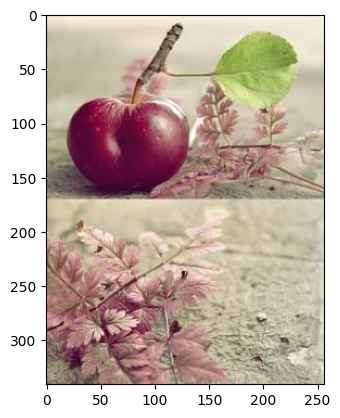

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

image_path = "/content/data/train/apple/007a0bec00a90a66.jpg"  # Replace with the actual path
try:
    img = Image.open(image_path)
    plt.imshow(img)
    plt.show()
except Exception as e:
    print(f"Error opening the image: {e}")


In [ ]:
import zipfile

# Define the path to the ZIP file
zip_file_path = "/content/images.zip"

# Extract the directory path where you want to unzip the contents
extracted_dir_path = "/content/"

# Unzip the file in the same directory
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)

print(f"Unzipped to {extracted_dir_path}")


Unzipped to /content/
